In [1]:
# Dependencies
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import scipy.stats as st
import time
import gmaps

# Import API keys
from config import api_key, g_key

# Configure the api_key for gmaps
gmaps.configure(api_key=g_key)

In [2]:
# Create the API Response in json format
base_url=f"https://api.covidactnow.org/v2/states.json?apiKey={api_key}"
response=requests.get(base_url).json()

In [3]:
# Create empty lists to hold the response info
state_name = []
population = []
case_density = []
icu_capacity_ratio = []
vax_initiated = []
vax_completed = []
cases = []
deaths = []
pos_tests = []
neg_tests = []
hospital_beds_capacity=[]
hospital_beds_current_usage=[]
hospital_beds_covid_usage=[]
icu_beds_capacity=[]
icu_beds_current_usage=[]
icu_beds_covid_usage=[]
last_update_date=[]
pos_case_rate = []

print("Beginning Data Retrieval")
print("----------------------------")

# Loop through the json response and perform a request and append the empty lists
for i in list(range(len(response))):
    state_name.append(response[i]["state"])
    print(f"Processing Record of {state_name[-1]} State")
    population.append(response[i]["population"])
    case_density.append(response[i]["metrics"]["caseDensity"])
    icu_capacity_ratio.append(response[i]["metrics"]["icuCapacityRatio"])
    vax_initiated.append(response[i]["metrics"]["vaccinationsInitiatedRatio"])
    vax_completed.append(response[i]["metrics"]["vaccinationsCompletedRatio"])
    cases.append(response[i]["actuals"]["cases"])
    deaths.append(response[i]["actuals"]["deaths"])
    pos_tests.append(response[i]["actuals"]["positiveTests"])
    neg_tests.append(response[i]["actuals"]["negativeTests"])
    hospital_beds_capacity.append(response[i]["actuals"]["hospitalBeds"]["capacity"])
    hospital_beds_current_usage.append(response[i]["actuals"]["hospitalBeds"]["currentUsageTotal"])
    hospital_beds_covid_usage.append(response[i]["actuals"]["hospitalBeds"]["currentUsageCovid"])
    icu_beds_capacity.append(response[i]["actuals"]["icuBeds"]["capacity"])
    icu_beds_current_usage.append(response[i]["actuals"]["icuBeds"]["currentUsageTotal"])
    icu_beds_covid_usage.append(response[i]["actuals"]["icuBeds"]["currentUsageCovid"])
    last_update_date.append(response[i]["lastUpdatedDate"])
    pos_case_rate.append(response[i]["actuals"]["positiveTests"]/(response[i]["actuals"]["negativeTests"]+response[i]["actuals"]["positiveTests"]))

print("-----------------------------")
print("Data Retrieval Complete")
print("-----------------------------")

Beginning Data Retrieval
----------------------------
Processing Record of AK State
Processing Record of AL State
Processing Record of AR State
Processing Record of AZ State
Processing Record of CA State
Processing Record of CO State
Processing Record of CT State
Processing Record of DC State
Processing Record of DE State
Processing Record of FL State
Processing Record of GA State
Processing Record of HI State
Processing Record of IA State
Processing Record of ID State
Processing Record of IL State
Processing Record of IN State
Processing Record of KS State
Processing Record of KY State
Processing Record of LA State
Processing Record of MA State
Processing Record of MD State
Processing Record of ME State
Processing Record of MI State
Processing Record of MN State
Processing Record of MO State
Processing Record of MP State
Processing Record of MS State
Processing Record of MT State
Processing Record of NC State
Processing Record of ND State
Processing Record of NE State
Processing Recor

In [4]:
# Creating a data frame to hold the retrieved data and dropping rows with missing data
initial_df=pd.DataFrame({"State": state_name, "Population":population, "Case Density": case_density, 
                 "ICU Capacity Ratio": icu_capacity_ratio, "Initiated Vaccinations Ratio": vax_initiated, 
                 "Completed Vaccinations Ratio": vax_completed,"Total Number of Cases": cases,"Death Toll": deaths,
                 "Positive Tests": pos_tests, "Negative Tests":neg_tests, "Positive Case Ratio": pos_case_rate,"Hospital Beds Capacity": hospital_beds_capacity,
                 "Hospital Beds Current Usage": hospital_beds_current_usage,"Hospital Beds COVID Usage":hospital_beds_covid_usage,
                 "ICU Beds Capacity":icu_beds_capacity,"ICU Beds Current Usage":icu_beds_current_usage,
                 "ICU Beds COVID Usage":icu_beds_covid_usage, "Last Update Date": last_update_date}).dropna()
pd.options.display.float_format = '{:.2f}'.format
initial_df["Hospital Beds Current Usage"]=initial_df["Hospital Beds Current Usage"].astype(int)
initial_df["Hospital Beds Capacity"]=initial_df["Hospital Beds Capacity"].astype(int)
initial_df["Hospital Beds COVID Usage"]=initial_df["Hospital Beds COVID Usage"].astype(int)
initial_df["ICU Beds Capacity"]=initial_df["ICU Beds Capacity"].astype(int)
initial_df["ICU Beds Current Usage"]=initial_df["ICU Beds Current Usage"].astype(int)
initial_df["ICU Beds COVID Usage"]=initial_df["ICU Beds COVID Usage"].astype(int)
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 52
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   State                         51 non-null     object 
 1   Population                    51 non-null     int64  
 2   Case Density                  51 non-null     float64
 3   ICU Capacity Ratio            51 non-null     float64
 4   Initiated Vaccinations Ratio  51 non-null     float64
 5   Completed Vaccinations Ratio  51 non-null     float64
 6   Total Number of Cases         51 non-null     int64  
 7   Death Toll                    51 non-null     int64  
 8   Positive Tests                51 non-null     int64  
 9   Negative Tests                51 non-null     int64  
 10  Positive Case Ratio           51 non-null     float64
 11  Hospital Beds Capacity        51 non-null     int32  
 12  Hospital Beds Current Usage   51 non-null     int32  
 13  Hospita

In [5]:
# Reading csv file containing latitude and longitude for each state
# Sources: https://www.kaggle.com/washimahmed/usa-latlong-for-state-abbreviations
# Corrected Washington State's Latitude and Longitude using: https://www.latlong.net/place/washington-the-usa-5989.html
file_path="Data/statelatlong.csv"
state_lat_lng_df=pd.read_csv(file_path)

# Merging the 2 data frames on State
covid_df=pd.merge(initial_df,state_lat_lng_df[["State","Latitude","Longitude"]], how="left",on="State").dropna()
covid_df

,State,Population,Case Density,ICU Capacity Ratio,Initiated Vaccinations Ratio,Completed Vaccinations Ratio,Total Number of Cases,Death Toll,Positive Tests,Negative Tests,Positive Case Ratio,Hospital Beds Capacity,Hospital Beds Current Usage,Hospital Beds COVID Usage,ICU Beds Capacity,ICU Beds Current Usage,ICU Beds COVID Usage,Last Update Date,Latitude,Longitude
0,AK,731545,139.90,0.88,0.59,0.52,134059,685,150892,2878406,0.05,1380,1050,230,129,113,49,2021-10-26,61.30,-158.78
1,AL,4903185,17.30,0.80,0.54,0.44,817747,15407,774249,5212678,0.13,14938,10517,727,1560,1255,179,2021-10-26,32.60,-86.68
2,AR,3017804,15.70,0.77,0.58,0.48,510406,8292,316953,3375296,0.09,8041,5619,457,938,721,156,2021-10-26,34.75,-92.13
3,AZ,7278717,35.30,0.63,0.61,0.53,1148641,20867,1171643,9548966,0.11,15532,11271,1657,2150,1348,401,2021-10-26,34.17,-111.93
4,CA,39512223,14.00,0.75,0.74,0.61,4869133,71639,4847452,81328439,0.06,61790,47332,3992,6943,5230,961,2021-10-26,37.27,-119.27
5,CO,5758736,44.30,0.85,0.67,0.61,731603,8273,725118,10003192,0.07,11173,7999,1234,1312,1118,380,2021-10-26,39.00,-105.55
6,CT,3565287,11.40,0.58,0.78,0.70,400301,8739,524830,10634054,0.05,7903,6510,256,1024,592,59,2021-10-26,41.52,-72.76
7,DC,705749,11.60,0.73,0.74,0.62,63879,1186,91685,2862143,0.03,3443,2673,84,335,244,15,2021-10-26,38.90,-77.01
8,DE,973764,31.40,0.84,0.69,0.60,142600,2064,160568,2523768,0.06,2895,2227,170,199,167,27,2021-10-26,39.15,-75.42
9,FL,21477737,8.70,0.73,0.69,0.59,3635410,58933,4290991,37126660,0.10,53036,40223,2276,6264,4577,563,2021-10-26,27.98,-83.83


In [6]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 50
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   State                         50 non-null     object 
 1   Population                    50 non-null     int64  
 2   Case Density                  50 non-null     float64
 3   ICU Capacity Ratio            50 non-null     float64
 4   Initiated Vaccinations Ratio  50 non-null     float64
 5   Completed Vaccinations Ratio  50 non-null     float64
 6   Total Number of Cases         50 non-null     int64  
 7   Death Toll                    50 non-null     int64  
 8   Positive Tests                50 non-null     int64  
 9   Negative Tests                50 non-null     int64  
 10  Positive Case Ratio           50 non-null     float64
 11  Hospital Beds Capacity        50 non-null     int32  
 12  Hospital Beds Current Usage   50 non-null     int32  
 13  Hospita

In [7]:
covid_df.head()

,State,Population,Case Density,ICU Capacity Ratio,Initiated Vaccinations Ratio,Completed Vaccinations Ratio,Total Number of Cases,Death Toll,Positive Tests,Negative Tests,Positive Case Ratio,Hospital Beds Capacity,Hospital Beds Current Usage,Hospital Beds COVID Usage,ICU Beds Capacity,ICU Beds Current Usage,ICU Beds COVID Usage,Last Update Date,Latitude,Longitude
0,AK,731545,139.90,0.88,0.59,0.52,134059,685,150892,2878406,0.05,1380,1050,230,129,113,49,2021-10-26,61.30,-158.78
1,AL,4903185,17.30,0.80,0.54,0.44,817747,15407,774249,5212678,0.13,14938,10517,727,1560,1255,179,2021-10-26,32.60,-86.68
2,AR,3017804,15.70,0.77,0.58,0.48,510406,8292,316953,3375296,0.09,8041,5619,457,938,721,156,2021-10-26,34.75,-92.13
3,AZ,7278717,35.30,0.63,0.61,0.53,1148641,20867,1171643,9548966,0.11,15532,11271,1657,2150,1348,401,2021-10-26,34.17,-111.93
4,CA,39512223,14.00,0.75,0.74,0.61,4869133,71639,4847452,81328439,0.06,61790,47332,3992,6943,5230,961,2021-10-26,37.27,-119.27


In [8]:
# Saving the data frame in a csv file
covid_df.to_csv("Output_Data/covid19_data.csv",index=False)

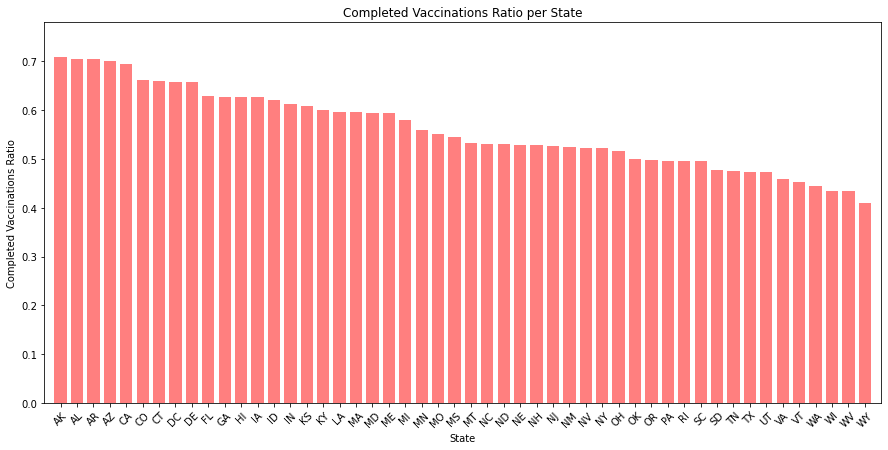

In [36]:
# Generate a bar plot showing the completed vaccinations ratio per state using Pandas.
covid_df["Completed Vaccinations Ratio"].sort_values(ascending=False).plot(kind="bar",color="red",width=0.75,figsize=(15,7), alpha=0.5)

# Create the ticks for our bar chart's x axis
state=covid_df["State"]
tick_locations = [value for value in range(len(state))]
plt.xticks(tick_locations, state, rotation=45)

# Give the chart a title, x label, and y label
plt.xlabel("State")
plt.ylabel("Completed Vaccinations Ratio")
plt.title("Completed Vaccinations Ratio per State")

# Set the limits of the x axis
plt.xlim(-1, len(state)) 

# Set the limits of the y axis
plt.ylim(0, max(covid_df["Completed Vaccinations Ratio"])*1.1) 

# Save the plot as png
plt.savefig("Images/Completed_Vaccinations_Ratio_per_State.png")

# Show plot
plt.show()

The r-value is: -0.10537279903471575


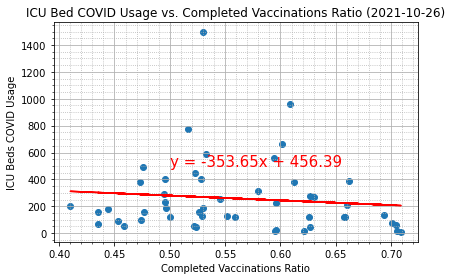

In [10]:
# Getting the last update date
last_update=covid_df["Last Update Date"].unique()[0]

# Setting the values for X and Y axis
x_values = covid_df["Completed Vaccinations Ratio"]
y_values = covid_df["ICU Beds COVID Usage"]

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)[2]

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.5,500),fontsize=15,color="red")

# Label plot
plt.title(f"ICU Bed COVID Usage vs. Completed Vaccinations Ratio ({last_update})")
plt.xlabel("Completed Vaccinations Ratio")
plt.ylabel("ICU Beds COVID Usage")

# Print the r-value
print(f"The r-value is: {correlation}")

# Give the chart a title, x label, and y label
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

# Formatting the plot
plt.tight_layout()

# Save the plot as png
plt.savefig("Images/ICU_Beds_COVID_Usage_vs_Completed_Vaccinations_Ratio.png")

# Show plot
plt.show()

The r-value is: 0.9791099967711484


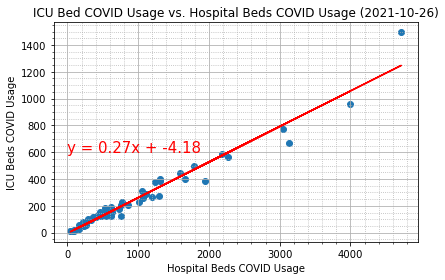

In [11]:
# Getting the last update date
last_update=covid_df["Last Update Date"].unique()[0]

# Setting the values for X and Y axis
x_values = covid_df["Hospital Beds COVID Usage"]
y_values = covid_df["ICU Beds COVID Usage"]

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)[2]

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.5,600),fontsize=15,color="red")

# Label plot
plt.title(f"ICU Bed COVID Usage vs. Hospital Beds COVID Usage ({last_update})")
plt.xlabel("Hospital Beds COVID Usage")
plt.ylabel("ICU Beds COVID Usage")

# Print the r-value
print(f"The r-value is: {correlation}")

# Give the chart a title, x label, and y label
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

# Formatting the plot
plt.tight_layout()

# Save the plot as png
plt.savefig("Images/ICU_Beds_COVID_Usage_vs_Hospital_Beds_COVID_Usage.png")

# Show plot
plt.show()

The r-value is: 0.9679963133009761


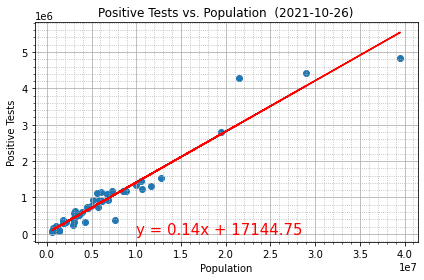

In [12]:
# Setting the values for X and Y axis
x_values = covid_df["Population"]
y_values = covid_df["Positive Tests"]

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)[2]

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10000000,1),fontsize=15,color="red")

# Label plot
plt.title(f"Positive Tests vs. Population  ({last_update})")
plt.xlabel("Population")
plt.ylabel("Positive Tests")

# Print the r-value
print(f"The r-value is: {correlation}")

# Give the chart a title, x label, and y label
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

# Formatting the plot
plt.tight_layout()

# Save the plot as png
plt.savefig("Images/Positive_Tests_vs_Population.png")

# Show plot
plt.show()

The r-value is: 0.963348888807446


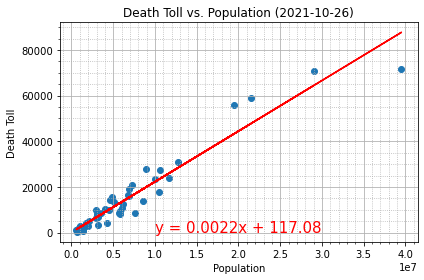

In [40]:
# Setting the values for X and Y axis
x_values = covid_df["Population"]
y_values = covid_df["Death Toll"]

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,4)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)[2]

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(10000000,1),fontsize=15,color="red")

# Label plot
plt.title(f"Death Toll vs. Population ({last_update})")
plt.xlabel("Population")
plt.ylabel("Death Toll")

# Print the r-value
print(f"The r-value is: {correlation}")

# Give the chart a title, x label, and y label
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

# Formatting the plot
plt.tight_layout()

# Save the plot as png
plt.savefig("Images/Death_Toll_vs_Population.png")

# Show plot
plt.show()

The r-value is: 0.2804409191119412


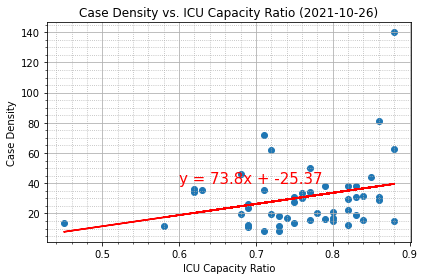

In [39]:
# Setting the values for X and Y axis
x_values = covid_df["ICU Capacity Ratio"]
y_values = covid_df["Case Density"]

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)[2]

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.6,40),fontsize=15,color="red")

# Label plot
plt.title(f"Case Density vs. ICU Capacity Ratio ({last_update})")
plt.xlabel("ICU Capacity Ratio")
plt.ylabel("Case Density")

# Print the r-value
print(f"The r-value is: {correlation}")

# Give the chart a title, x label, and y label
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

# Formatting the plot
plt.tight_layout()

# Save the plot as png
plt.savefig("Images/Case_Density_vs_ICU_Capacity_Ratio.png")

# Show plot
plt.show()

The r-value is: -0.2467585403741487


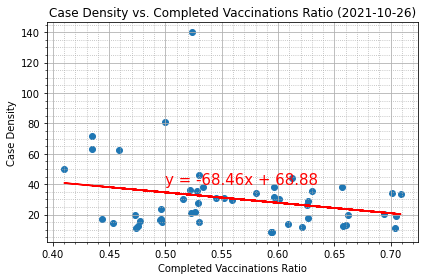

In [15]:
# Setting the values for X and Y axis
x_values = covid_df["Completed Vaccinations Ratio"]
y_values = covid_df["Case Density"]

# Run linear regression
(slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
correlation = st.linregress(x_values, y_values)[2]

# Plot scatter plot
plt.scatter(x_values,y_values)

# Plot regression line
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(0.5,40),fontsize=15,color="red")

# Label plot
plt.title(f"Case Density vs. Completed Vaccinations Ratio ({last_update})")
plt.xlabel("Completed Vaccinations Ratio")
plt.ylabel("Case Density")

# Print the r-value
print(f"The r-value is: {correlation}")

# Give the chart a title, x label, and y label
plt.minorticks_on()
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':')

# Formatting the plot
plt.tight_layout()

# Save the plot as png
plt.savefig("Images/Case_Density_vs_Completed_Vaccinations_Ratio.png")

# Show plot
plt.show()

In [16]:
# Using the template add the state marks to the heatmap
info_box_template = """
<dl>
<dt>State</dt><dd>{State}</dd>
<dt>Total Number of Cases</dt><dd>{Total Number of Cases}</dd>
<dt>Death Toll</dt><dd>{Death Toll}</dd>
</dl>
"""
# Store the DataFrame Row
state_info = [info_box_template.format(**row) for index, row in covid_df.iterrows()]
locations = covid_df[["Latitude", "Longitude"]]

In [17]:
# Set the parameters for the map
death_toll= covid_df["Death Toll"]
intensity=max(covid_df["Death Toll"])

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=death_toll, 
                                 dissipating=False, max_intensity=intensity,
                                 point_radius=5)
marker_layer= gmaps.marker_layer(locations,info_box_content=state_info)

# Add layer
fig.add_layer(heat_layer)
fig.add_layer(marker_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [18]:
# Using the template add the state marks to the heatmap
info_box_template = """
<dl>
<dt>State</dt><dd>{State}</dd>
<dt>Total Number of Cases</dt><dd>{Total Number of Cases}</dd>
<dt>Population</dt><dd>{Population}</dd>
</dl>
"""
# Store the DataFrame Row
state_info = [info_box_template.format(**row) for index, row in covid_df.iterrows()]
locations = covid_df[["Latitude", "Longitude"]]

In [19]:
# Set the parameters for the map
total_cases= covid_df["Total Number of Cases"]
intensity=max(covid_df["Total Number of Cases"])

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=total_cases, 
                                 dissipating=False, max_intensity=intensity,
                                 point_radius=5)
marker_layer= gmaps.marker_layer(locations,info_box_content=state_info)

# Add layer
fig.add_layer(heat_layer)
fig.add_layer(marker_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [20]:
# Using the template add the state marks to the heatmap
info_box_template = """
<dl>
<dt>State</dt><dd>{State}</dd>
<dt>ICU Beds COVID Usage</dt><dd>{ICU Beds COVID Usage}</dd>
<dt>Case Density</dt><dd>{Case Density}</dd>
</dl>
"""
# Store the DataFrame Row
state_info = [info_box_template.format(**row) for index, row in covid_df.iterrows()]
locations = covid_df[["Latitude", "Longitude"]]

In [21]:
# Set the parameters for the map
icu_covid_beds= covid_df["ICU Beds COVID Usage"]
intensity=max(covid_df["ICU Beds COVID Usage"])

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=icu_covid_beds, 
                                 dissipating=False, max_intensity=intensity,
                                 point_radius=5)
marker_layer= gmaps.marker_layer(locations,info_box_content=state_info)

# Add layer
fig.add_layer(heat_layer)
fig.add_layer(marker_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [22]:
# Using the template add the state marks to the heatmap
info_box_template = """
<dl>
<dt>State</dt><dd>{State}</dd>
<dt>Population</dt><dd>{Population}</dd>
<dt>Case Density</dt><dd>{Case Density}</dd>
</dl>
"""
# Store the DataFrame Row
state_info = [info_box_template.format(**row) for index, row in covid_df.iterrows()]
locations = covid_df[["Latitude", "Longitude"]]

In [23]:
# Set the parameters for the map
case_density= covid_df["Case Density"]
intensity=max(covid_df["Case Density"])

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=case_density, 
                                 dissipating=False, max_intensity=intensity,
                                 point_radius=5)
marker_layer= gmaps.marker_layer(locations,info_box_content=state_info)

# Add layer
fig.add_layer(heat_layer)
fig.add_layer(marker_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))